In [1]:
import csv
from datetime import datetime
from dateutil.parser import isoparse
import numpy as np

In [2]:
def moving_average(x, z, windowsize = 1, ensure_centered = True):
    
    def inner_function(xc):
        
        if ensure_centered:
            im = np.where(np.logical_and(x > (xc - windowsize / 2.0), x < xc))
            ip = np.where(np.logical_and(x < (xc + windowsize / 2.0), x >= xc))
            return 0.5*np.mean(z[im]) + 0.5*np.mean(z[ip]) if len(im) > 0 and len(ip) > 0 else np.nan
        else:
            i = np.where(np.logical_and(x > (xc - windowsize / 2.0), x < (xc + windowsize / 2.0)))
            return np.mean(z[i])
    return inner_function


In [3]:
def read_gps_data(filename):
    date = []
    ux = []
    uy = []
    uz = []
    sig_ux = []
    sig_uy = []
    sig_uz = []

    with open(filename, 'r') as file:
        reader = csv.reader(file, delimiter = ',')
    
        for _ in range(5):
            next(reader)
    
        line = next(reader)[0]
        import re
        match = re.search('Latitude: ([+-]?([0-9]*[.])?[0-9]+)', line)
        if match:
            lat = float(match.group(1))
        match = re.search('Longitude: ([+-]?([0-9]*[.])?[0-9]+)', line)
        if match:
            lon = float(match.group(1))
        for _ in range(3):
            next(reader)
            
        for row in reader:
            date += [isoparse(row[0])]
            ux += [float(row[1])]
            uy += [float(row[2])]
            uz += [float(row[3])]
            sig_ux += [float(row[4])]
            sig_uy += [float(row[5])]
            sig_uz += [float(row[6])]
    
    date = np.array(date, dtype = np.datetime64)
    ux = np.array(ux)
    uy = np.array(uy)
    uz = np.array(uz)
    sig_ux = np.array(sig_ux)
    sig_uy = np.array(sig_uy)
    sig_uz = np.array(sig_uz)
    
    return date, ux, uy, uz, sig_ux, sig_uy, sig_uz, lat, lon


In [4]:
def denoised_indexes(dates, ux, uy, uz):
    
    from scipy.signal import detrend
    from scipy.optimize import fsolve
    from scipy.special import erf
    
    def find_zscore(f):
        def inner_function(zscore):
            return 1 - f - erf(zscore / np.sqrt(2.0))
        
        return fsolve(inner_function, 3)
    
    ux_m = ux
    uy_m = uy
    uz_m = uz
    dates_m = dates
    
    cleared = False
    
    while not cleared:
        ux_m = ux_m - np.mean(ux)
        uy_m = uy_m - np.mean(uy)
        uz_m = uz_m - np.mean(uz)
    
        ux_m = detrend(ux_m)
        uy_m = detrend(uy_m)
        uz_m = detrend(uz_m)

        zscore_ux = np.abs(ux_m) / np.std(ux_m)
        zscore_uy = np.abs(uy_m) / np.std(uy_m)
        zscore_uz = np.abs(uz_m) / np.std(uz_m)
    
        number_of_points = ux_m.size
    
        f = 1/number_of_points
        
        max_zscore = find_zscore(f)
        
        i = np.where(np.logical_and(np.logical_and(zscore_ux <= max_zscore, zscore_uy <= max_zscore),zscore_uz <= max_zscore))
        
        if len(i[0]) == number_of_points:
            cleared = True
        else:
            ux_m = ux_m[i]
            uy_m = uy_m[i]
            uz_m = uz_m[i]
            dates_m = dates_m[i]
        
    _, indexes, _ = np.intersect1d(dates, dates_m, assume_unique = True, return_indices = True)
    
    return indexes
    

In [5]:
def compute_strains_3stations(lons, lats):

    from numpy.linalg import inv
    
    xcentroid = np.mean(lons)
    ycentroid = np.mean(lats)
        
    dE1 = (lons[0] - xcentroid) * 111.0 * np.cos(np.deg2rad(ycentroid));
    dE2 = (lons[1] - xcentroid) * 111.0 * np.cos(np.deg2rad(ycentroid));
    dE3 = (lons[2] - xcentroid) * 111.0 * np.cos(np.deg2rad(ycentroid));
    dN1 = (lats[0] - ycentroid) * 111.0;
    dN2 = (lats[1] - ycentroid) * 111.0;
    dN3 = (lats[2] - ycentroid) * 111.0;
    
    Design_Matrix = np.array(
            [[1, 0, dE1, dN1, 0, 0], [0, 1, 0, 0, dE1, dN1], [1, 0, dE2, dN2, 0, 0], [0, 1, 0, 0, dE2, dN2],
             [1, 0, dE3, dN3, 0, 0], [0, 1, 0, 0, dE3, dN3]]);

    # Invert to get the components of the velocity gradient tensor.
    DMinv = inv(Design_Matrix);
    
    def inner_function(uxs, uys):
        (VE1, VE2, VE3) = uxs
        (VN1, VN2, VN3) = uys
    
        obs_vel = np.array([[VE1], [VN1], [VE2], [VN2], [VE3], [VN3]]);

        vel_grad = np.dot(DMinv, obs_vel);  # this is the money step.
    
        dudx = vel_grad[2][0];
        dudy = vel_grad[3][0];
        dvdx = vel_grad[4][0];
        dvdy = vel_grad[5][0];
    
        exx = dudx;
        exy = (0.5 * (dvdx + dudy));
        eyy = dvdy;
        rot = (0.5 * (dvdx - dudy));
        
        return [exx, exy, eyy, rot];
    
    return inner_function


## Read GPS Data from file and denoise:

/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


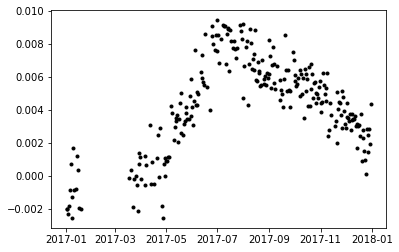

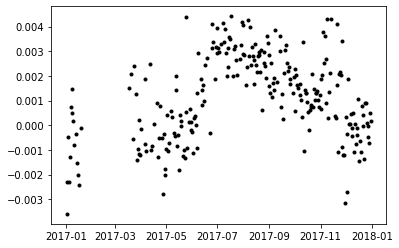

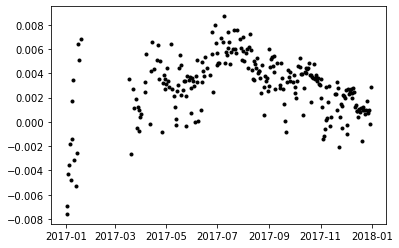

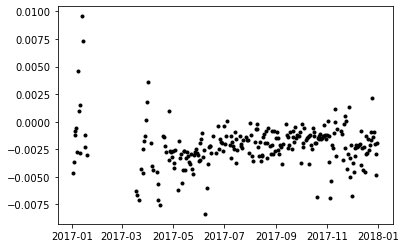

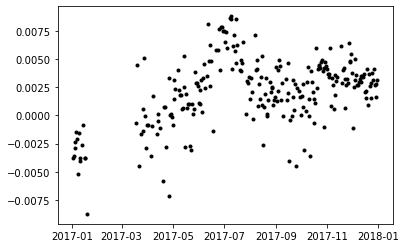

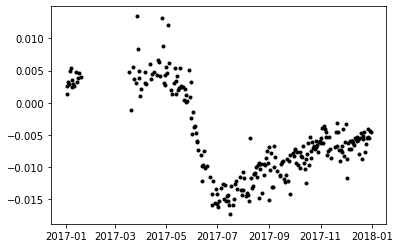

In [7]:
date_linc, ux_linc, uy_linc, uz_linc, _, _, _, lat_linc, lon_linc = read_gps_data('data/GPS/LINC-cwu-nam14-gpos.csv')
date_mins, ux_mins, uy_mins, uz_mins, _, _, _, lat_mins, lon_mins = read_gps_data('data/GPS/MINS-cwu-nam14-gpos.csv')
date_knol, ux_knol, uy_knol, uz_knol, _, _, _, lat_knol, lon_knol = read_gps_data('data/GPS/KNOL-cwu-nam14-gpos.csv')
#date_p630, ux_p630, uy_p630, uz_p630, _, _, _, lat_p630, lon_p630 = read_gps_data('data/GPS/P630-cwu-nam14-gpos.csv')
#date_shrc, ux_shrc, uy_shrc, uz_shrc, _, _, _, lat_shrc, lon_shrc = read_gps_data('data/GPS/SHRC-cwu-nam14-gpos.csv')

i_linc = np.where(date_linc > np.datetime64('2014-01-01'))
i_knol = np.where(date_knol > np.datetime64('2014-01-01'))
i_mins = np.where(date_mins > np.datetime64('2014-01-01'))

(date_knol, ux_knol, uy_knol, uz_knol) = \
    (date_knol[i_knol], ux_knol[i_knol], uy_knol[i_knol], uz_knol[i_knol])

(date_mins, ux_mins, uy_mins, uz_mins) = \
    (date_mins[i_mins], ux_mins[i_mins], uy_mins[i_mins], uz_mins[i_mins])

(date_linc, ux_linc, uy_linc, uz_linc) = \
    (date_linc[i_linc], ux_linc[i_linc], uy_linc[i_linc], uz_linc[i_linc])

indexes_knol = denoised_indexes(date_knol, ux_knol, uy_knol, uz_knol)
indexes_mins = denoised_indexes(date_mins, ux_mins, uy_mins, uz_mins)
indexes_linc = denoised_indexes(date_linc, ux_linc, uy_linc, uz_linc)

(date_knol, ux_knol, uy_knol, uz_knol) = \
    (date_knol[indexes_knol], ux_knol[indexes_knol], uy_knol[indexes_knol], uz_knol[indexes_knol])

(date_mins, ux_mins, uy_mins, uz_mins) = \
    (date_mins[indexes_mins], ux_mins[indexes_mins], uy_mins[indexes_mins], uz_mins[indexes_mins])

(date_linc, ux_linc, uy_linc, uz_linc) = \
    (date_linc[indexes_linc], ux_linc[indexes_linc], uy_linc[indexes_linc], uz_linc[indexes_linc])



# Align data:

_, indexes_mins, indexes_linc = np.intersect1d(date_mins, date_linc, assume_unique = True, return_indices = True)

(date_mins, ux_mins, uy_mins, uz_mins) = \
    (date_mins[indexes_mins], ux_mins[indexes_mins], uy_mins[indexes_mins], uz_mins[indexes_mins])

(date_linc, ux_linc, uy_linc, uz_linc) = \
    (date_linc[indexes_linc], ux_linc[indexes_linc], uy_linc[indexes_linc], uz_linc[indexes_linc])

_, indexes_linc, indexes_knol = np.intersect1d(date_linc, date_knol, assume_unique = True, return_indices = True)

(date_knol, ux_knol, uy_knol, uz_knol) = \
    (date_knol[indexes_knol], ux_knol[indexes_knol], uy_knol[indexes_knol], uz_knol[indexes_knol])

(date_linc, ux_linc, uy_linc, uz_linc) = \
    (date_linc[indexes_linc], ux_linc[indexes_linc], uy_linc[indexes_linc], uz_linc[indexes_linc])

(date_mins, ux_mins, uy_mins, uz_mins) = \
    (date_mins[indexes_linc], ux_mins[indexes_linc], uy_mins[indexes_linc], uz_mins[indexes_linc])

# Detrend:
from scipy.signal import detrend
ux_mins -= np.mean(ux_mins)
ux_mins = detrend(ux_mins)
uy_mins -= np.mean(uy_mins)
uy_mins = detrend(uy_mins)

ux_linc -= np.mean(ux_linc)
ux_linc = detrend(ux_linc)
uy_linc -= np.mean(uy_linc)
uy_linc = detrend(uy_linc)

ux_knol -= np.mean(ux_knol)
ux_knol = detrend(ux_knol)
uy_knol -= np.mean(uy_knol)
uy_knol = detrend(uy_knol)

i_linc = np.where(np.logical_and(date_linc > np.datetime64('2017-01-01'), date_linc < np.datetime64('2018-01-01')))
i_knol = np.where(np.logical_and(date_knol > np.datetime64('2017-01-01'), date_knol < np.datetime64('2018-01-01')))
i_mins = np.where(np.logical_and(date_mins > np.datetime64('2017-01-01'), date_mins < np.datetime64('2018-01-01')))

import matplotlib.pylab as plt
plt.plot(date_linc[i_linc], ux_linc[i_linc], 'k.')
plt.show()
plt.plot(date_linc[i_linc], uy_linc[i_linc], 'k.')
plt.show()
plt.plot(date_knol[i_knol], ux_knol[i_knol], 'k.')
plt.show()
plt.plot(date_knol[i_knol], uy_knol[i_knol], 'k.')
plt.show()
plt.plot(date_mins[i_mins], ux_mins[i_mins], 'k.')
plt.show()
plt.plot(date_mins[i_mins], uy_mins[i_mins], 'k.')
plt.show()


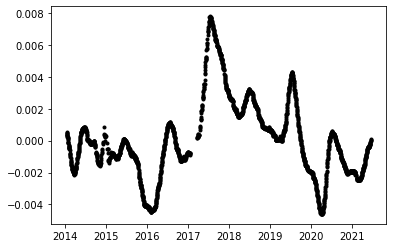

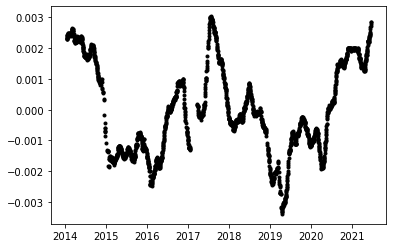

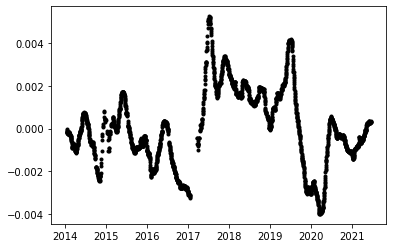

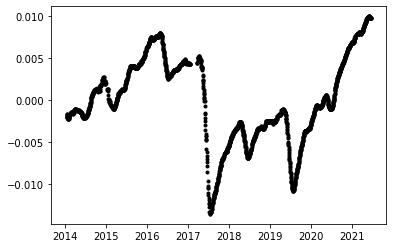

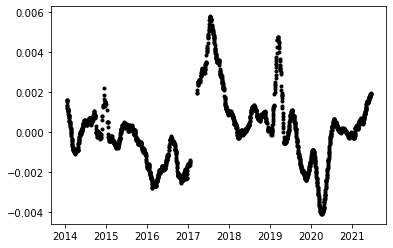

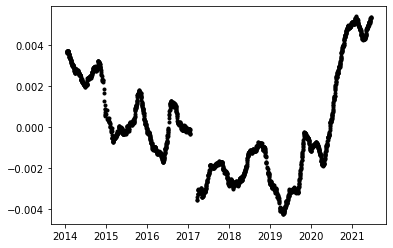

In [8]:
window = np.timedelta64(60, 'D')
date = date_linc

f_ma = moving_average(date, ux_linc, windowsize = window, ensure_centered = False)
moving_average_ux_linc = np.zeros_like(ux_linc)

for index, d in enumerate(date):
    moving_average_ux_linc[index] = f_ma(d)
    
f_ma = moving_average(date, uy_linc, windowsize = window, ensure_centered = False)
moving_average_uy_linc = np.zeros_like(ux_linc)

for index, d in enumerate(date):
    moving_average_uy_linc[index] = f_ma(d)

    
    
f_ma = moving_average(date, ux_mins, windowsize = window, ensure_centered = False)
moving_average_ux_mins = np.zeros_like(ux_mins)

for index, d in enumerate(date):
    moving_average_ux_mins[index] = f_ma(d)
    
f_ma = moving_average(date, uy_mins, windowsize = window, ensure_centered = False)
moving_average_uy_mins = np.zeros_like(ux_mins)

for index, d in enumerate(date):
    moving_average_uy_mins[index] = f_ma(d)

    
    
f_ma = moving_average(date, ux_knol, windowsize = window, ensure_centered = False)
moving_average_ux_knol = np.zeros_like(ux_knol)

for index, d in enumerate(date):
    moving_average_ux_knol[index] = f_ma(d)
    
f_ma = moving_average(date, uy_knol, windowsize = window, ensure_centered = False)
moving_average_uy_knol = np.zeros_like(ux_knol)

for index, d in enumerate(date):
    moving_average_uy_knol[index] = f_ma(d)
    
plt.plot(date, moving_average_ux_linc,'k.');plt.show()
plt.plot(date, moving_average_uy_linc,'k.');plt.show()

plt.plot(date, moving_average_ux_mins,'k.');plt.show()
plt.plot(date, moving_average_uy_mins,'k.');plt.show()

plt.plot(date, moving_average_ux_knol,'k.');plt.show()
plt.plot(date, moving_average_uy_knol,'k.');plt.show()

## Calcualte strains, isolate time period of interest, and detrend:

In [34]:
lats = np.array([lat_linc, lat_mins, lat_knol])
lons = np.array([lon_linc, lon_mins, lon_knol])

strain_computer = compute_strains_3stations(lons, lats)

mean_normal_strain = np.zeros_like(ux_linc)
max_shear_strain = np.zeros_like(ux_linc)

for index, (ux_1, ux_2, ux_3, uy_1, uy_2, uy_3) in enumerate(zip(moving_average_ux_linc, moving_average_ux_mins, moving_average_ux_knol, moving_average_uy_linc, moving_average_uy_mins, moving_average_uy_knol)):
    [exx, exy, eyy, rot] = strain_computer((ux_1, ux_2, ux_3), (uy_1, uy_2, uy_3))
    mean_normal_strain[index] = (exx + eyy) / 2.0
    T = np.array([[exx, exy], [exy, eyy]]);
    w, v = np.linalg.eig(T);
    max_shear_strain[index] = (w[0] - w[1]) * 0.5

date = date_linc
i = np.where(np.logical_and(date > np.datetime64('2017-03-01'), date < np.datetime64('2017-09-01')))
mean_normal_strain[i] = np.nan
max_shear_strain[i] = np.nan


i = np.where(date < np.datetime64('2017-03-01'))

mean_normal_strain[i] = mean_normal_strain[i] - np.mean(mean_normal_strain[i])
mean_normal_strain[i] = detrend(mean_normal_strain[i])
max_shear_strain[i] -= np.mean(max_shear_strain[i])
max_shear_strain[i] = detrend(max_shear_strain[i])

i = np.where(date > np.datetime64('2017-09-01'))
mean_normal_strain[i] -= np.mean(mean_normal_strain[i])
mean_normal_strain[i] = detrend(mean_normal_strain[i])
max_shear_strain[i] -= np.mean(max_shear_strain[i])
max_shear_strain[i] = detrend(max_shear_strain[i])



In [15]:
from EddyData import EddyData
import numpy as np

data = EddyData('data/HSL_data.csv')
data.filter_by_ustar(0.3)
data.denoise('co2_flux')
#co2_ts = data.detrend('co2_flux')
co2_ts = data.co2_flux
co2_moving_average_function = moving_average(data.time,co2_ts, windowsize = np.timedelta64('180','D'))
co2_moving_average = np.zeros_like(data.co2_flux)
for index, t in enumerate(data.time):
    co2_moving_average[index] = co2_moving_average_function(t)
    

/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/hilley/opt/miniconda2/envs/topoanalysis/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


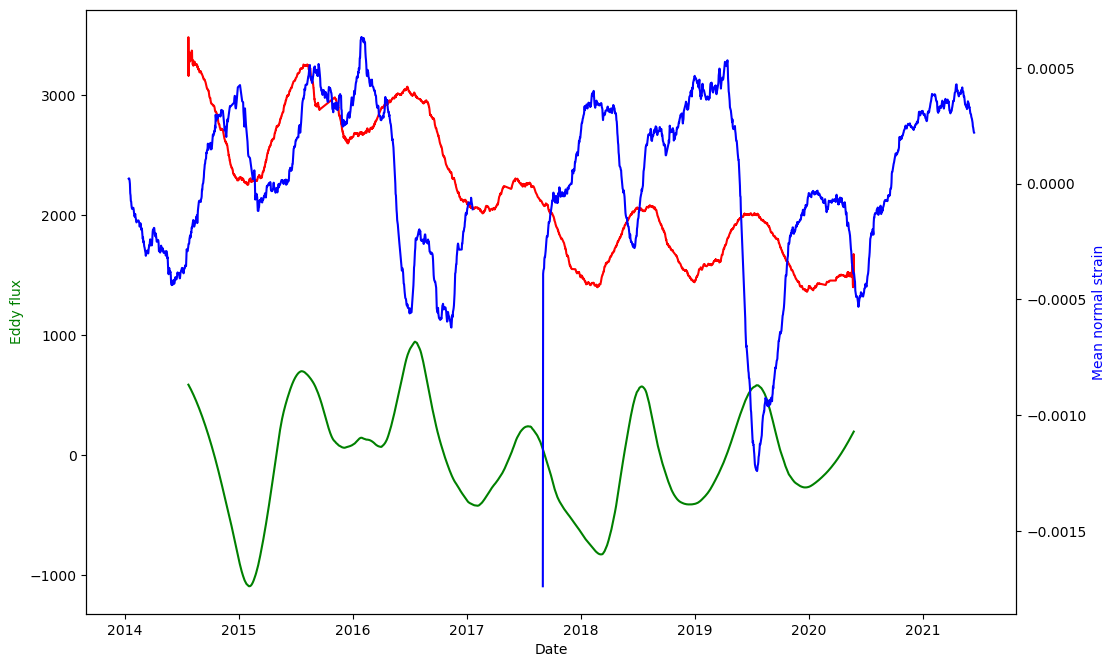

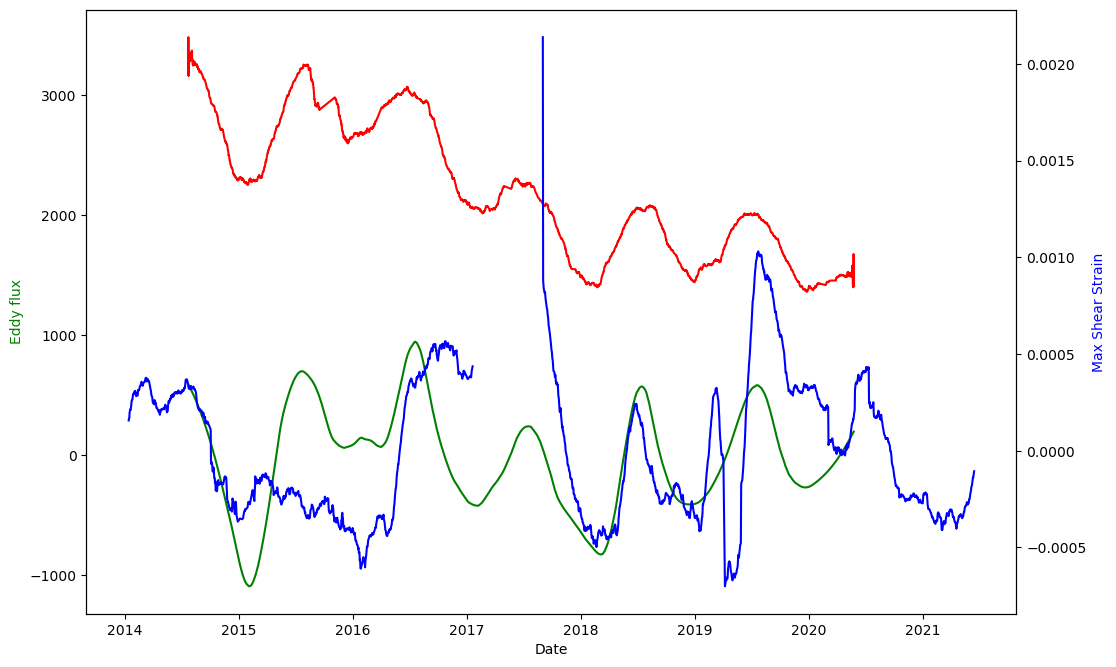

In [35]:
from scipy.io import loadmat
import matplotlib.pylab as plt

t_ec_number = loadmat('t_interp.mat')['t_interp'][0]
smoothed_CO2_flux = loadmat('smoothed_interpolation_CO2detrend_180d.mat')['smoothed_interpolation_CO2detrend_180d'][0]

# Fix dates:

time_difference = np.array([np.timedelta64(int((offset-203.0)*24*60)+2,'m') for offset in t_ec_number], dtype = np.timedelta64)
dates_ec = np.datetime64('2014-07-22') + time_difference

fig, ax1 = plt.subplots(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

ax2 = ax1.twinx()
ax1.plot(dates_ec, smoothed_CO2_flux, 'g-')
ax2.plot(date, mean_normal_strain, 'b-')
ax1.plot(data.time, co2_moving_average,'r-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Eddy flux', color='g')
ax2.set_ylabel('Mean normal strain', color='b')

plt.show()

fig, ax1 = plt.subplots(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

ax2 = ax1.twinx()
ax1.plot(dates_ec, smoothed_CO2_flux, 'g-')
ax2.plot(date, max_shear_strain, 'b-')
ax1.plot(data.time, co2_moving_average,'r-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Eddy flux', color='g')
ax2.set_ylabel('Max Shear Strain', color='b')

plt.show()

